In [159]:
import os
import pandas as pd
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

from typing import List

In [160]:
patterns = "[«»A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [161]:
def create_dataframe_from_csv(csv_path: str) -> pd.DataFrame:
    df_csv = pd.read_csv(csv_path)
    txt = []
    for absolute_path, rating in zip(df_csv['absolute_path'], df_csv['rating']):
        # Чтение текста из файла
        with open(absolute_path, 'r', encoding='utf-8') as file:
            text = file.read()
            # Добавление текста и рейтинга в список
            txt.append((text, rating)) 
    return pd.DataFrame(txt, columns=['review', 'rating'])

In [176]:
df = create_dataframe_from_csv(os.path.join("/Users", "wardonne", "Desktop", "Lab_python", "PP_2_Lab", "1.csv"))
df['rating'] = df['rating'].replace(1,0).replace(2,1).replace(3,2).replace(4,3).replace(5,4)
df

,review,rating
0,За стенкой. История Отиса Ревиаля\nПлюсы:-Прия...,0
1,"Её тёмные крылья\nПрочитала, дочитала, вымучил...",0
2,Тринадцать\nДичайше скучная история. Как миним...,0
3,Моя дорогая Оли...\nИ вот опять: с каждого угл...,0
4,"Почти идеальный брак\nИтак, рецензии пишу редк...",0
...,...,...
4995,"До свидания, Рим!\nЛёгкая книга, показывающая ...",4
4996,Оппенгеймер. Триумф и трагедия Американского П...,4
4997,Теория бесконечных обезьян\nПокупая первую для...,4
4998,Чёрные кувшинки\nИстория убийств в уютной фран...,4


In [163]:
def preprocess_and_lemmatize(review: str) -> str:
    review = re.sub(patterns, ' ', review)
    tokens = review.lower().split()
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stopwords_ru:
            preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

In [177]:
df['review'] = df['review'].apply(preprocess_and_lemmatize)
df.head()

,review,rating
0,стенка история отис ревиаля плюс приятный слог...,0
1,её тёмный крыло прочитать дочитать вымучить из...,0
2,тринадцать дикий скучный история минимум треть...,0
3,дорогой оля каждый угол кричать книга восхваля...,0
4,идеальный брак итак рецензия писать редко прав...,0


In [165]:
vectorizer = CountVectorizer(max_features=15000)

# Преобразование данных в матрицу
sparse_matrix = vectorizer.fit_transform(df['review']).toarray()

# Разделение данных
x_train, x_test_valid, y_train, y_test_valid = train_test_split(
    sparse_matrix, np.array(df['rating']), test_size=0.2
)
x_test, x_valid, y_test, y_valid = train_test_split(
    x_test_valid, y_test_valid, test_size=0.5
)

In [166]:
class_counts = dict(zip(*np.unique(y_train, return_counts=True)))
print(class_counts)

{0: 813, 1: 783, 2: 818, 3: 796, 4: 790}


In [167]:
class CustomLogisticRegression(nn.Module):
    def __init__(self, input_size=15000, hidden_size1=150, hidden_size2=15, output_size=5):
        super(CustomLogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=1)

In [168]:
model = CustomLogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

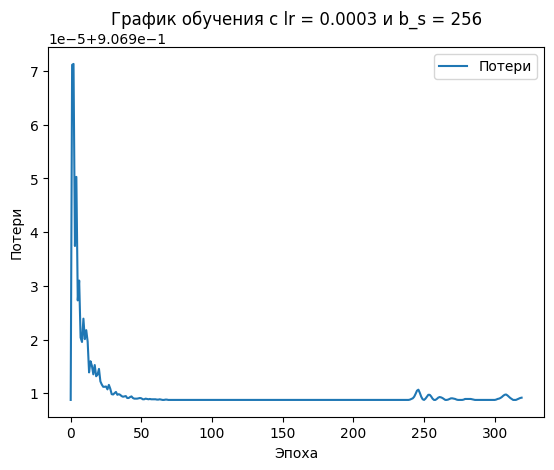

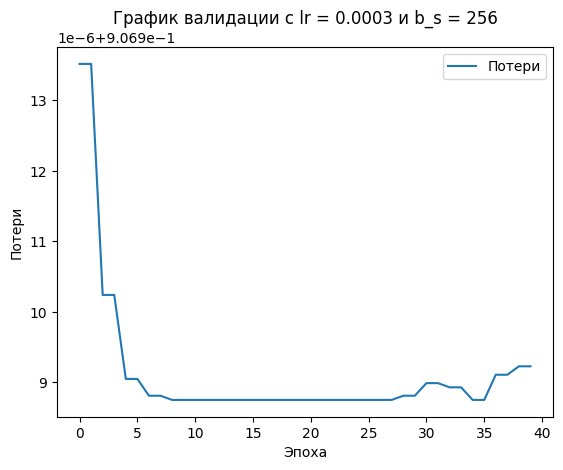

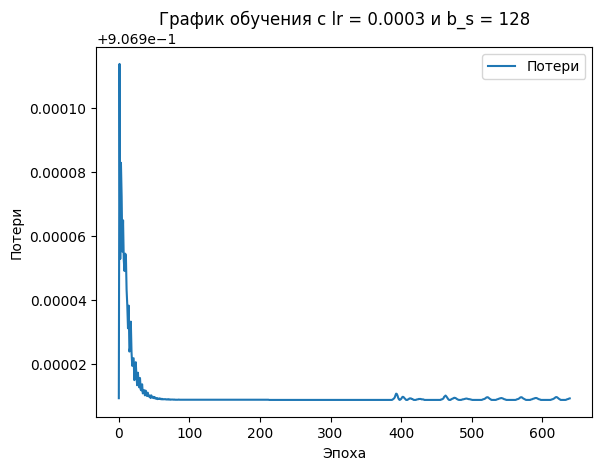

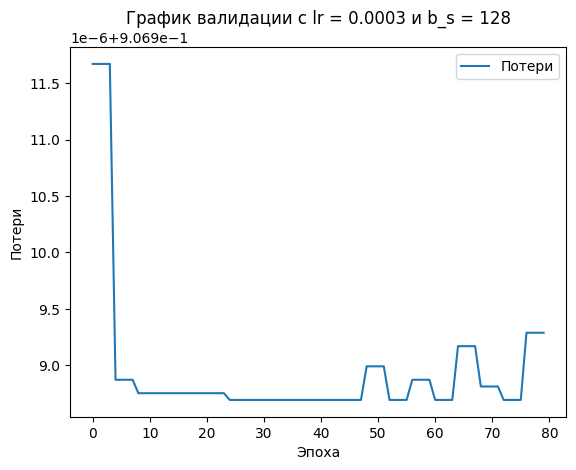

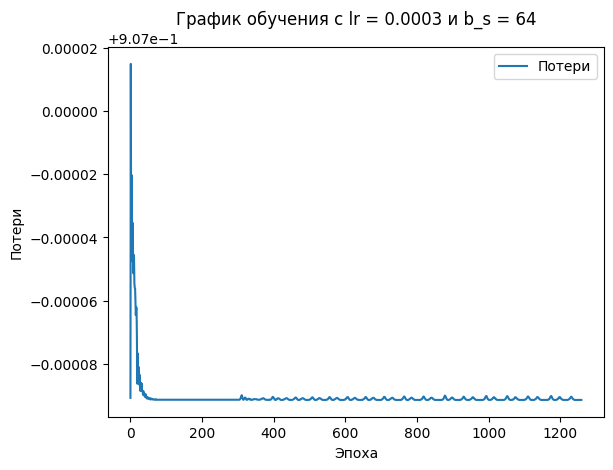

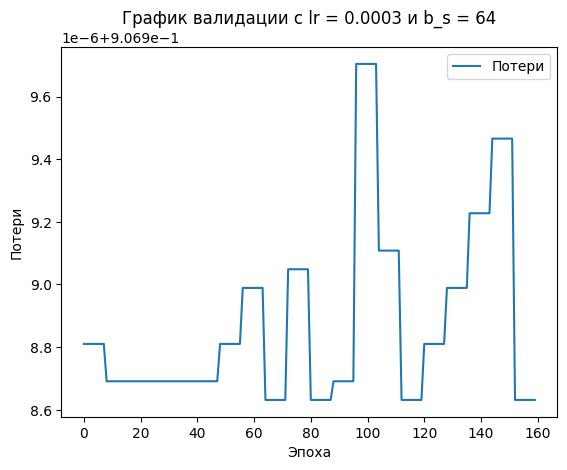

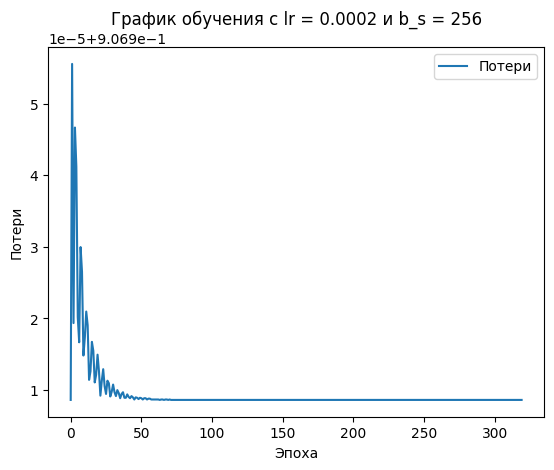

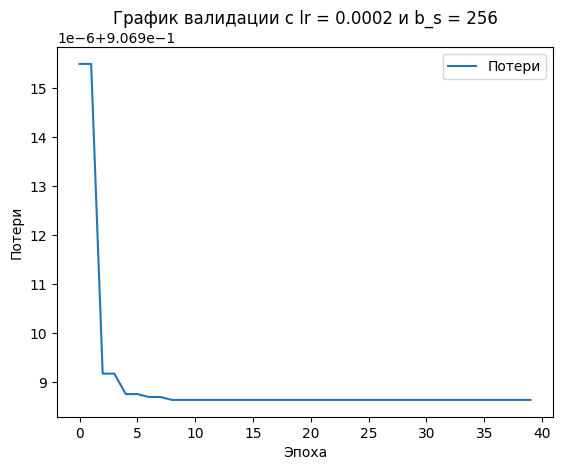

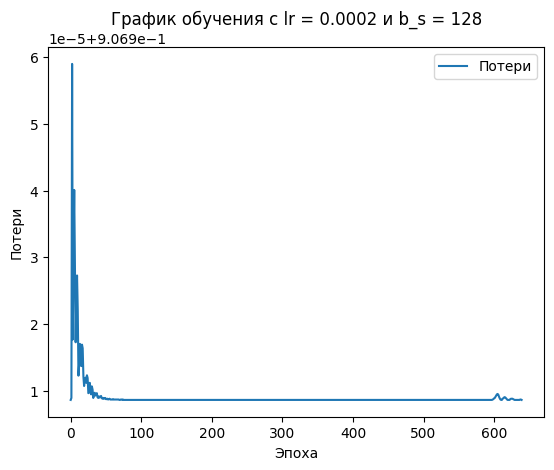

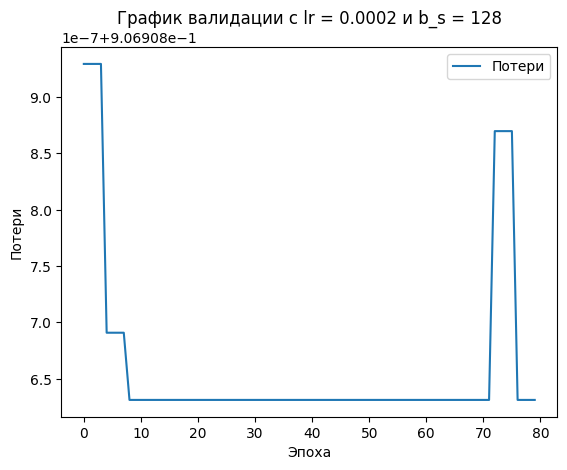

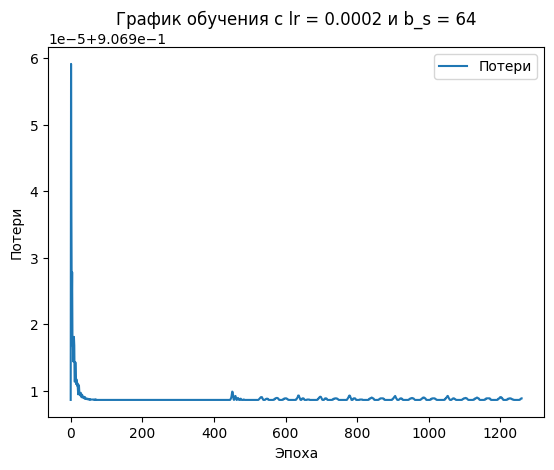

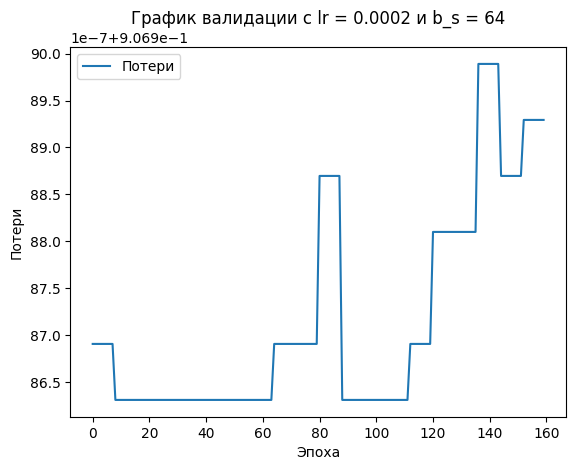

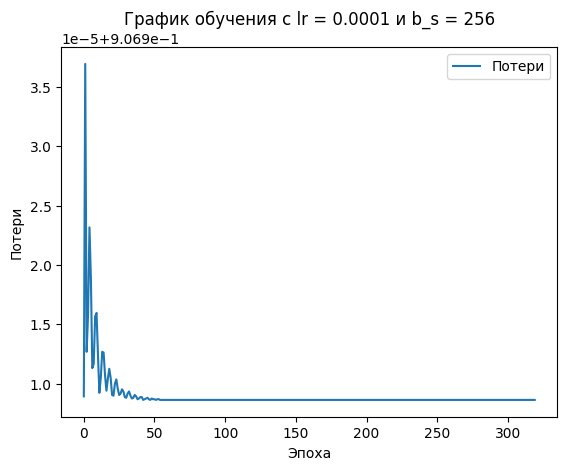

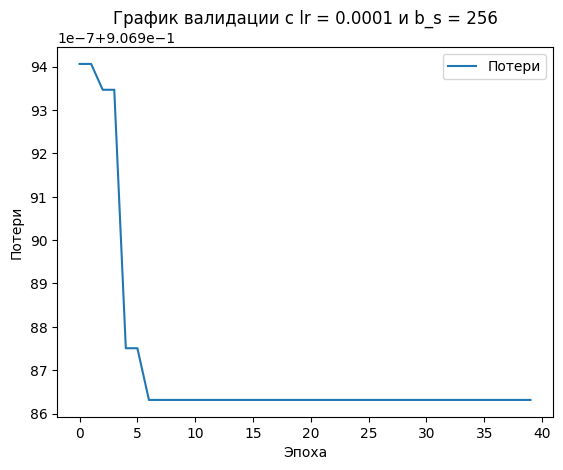

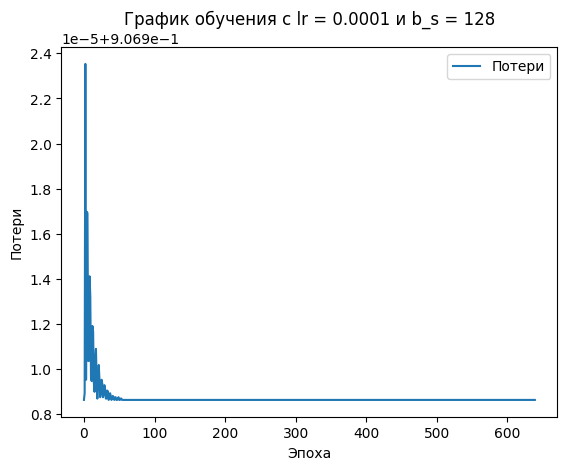

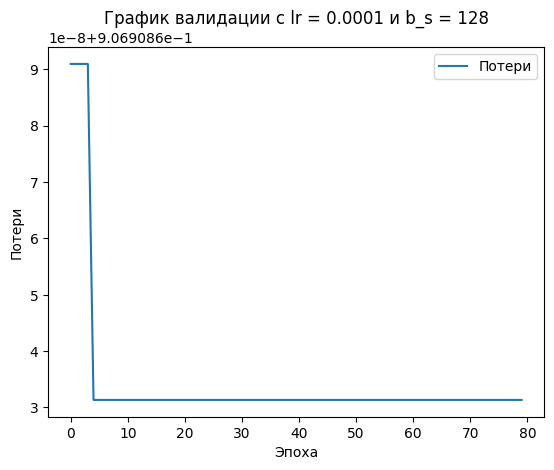

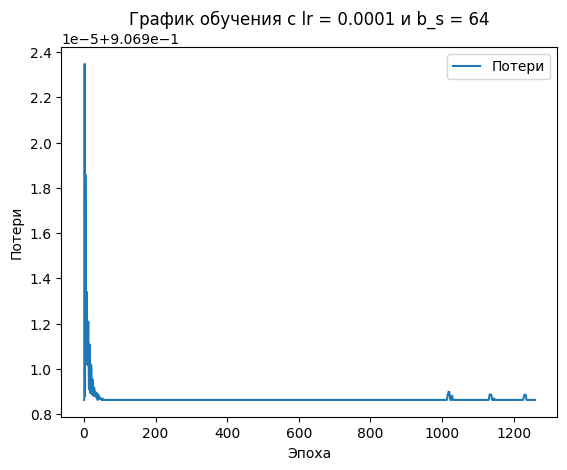

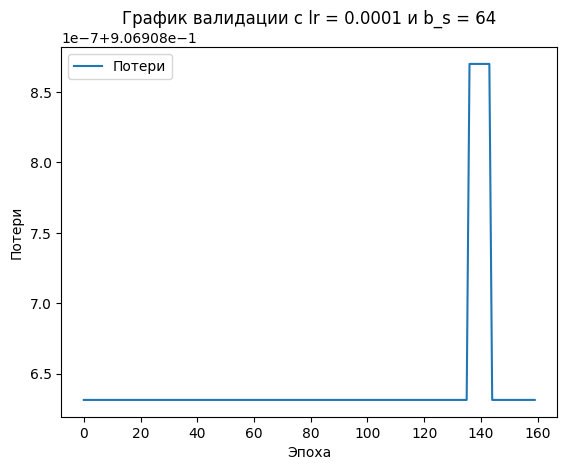

In [172]:
learning_rate = [0.0003, 0.0002, 0.0001]
batch_size = [256, 128, 64]
for lr in learning_rate:
    for bs in batch_size:
        data = torch.utils.data.DataLoader(x_train, batch_size=bs, shuffle=True)
        val_data = torch.utils.data.DataLoader(x_valid, batch_size=bs, shuffle=True)
        optimizer = torch.optim.Adam(params=model.parameters() , lr=lr)
        epochs = 20
        model.train()
        loss_test = []
        loss_val=[]
        for epoch in range(epochs):
            for elem in data:
                y_pred = model(x_train)
                loss = criterion(y_pred, y_train)
                loss_test.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            model.eval()
            for elem in val_data:
                y_pred = model(x_train)
                loss = criterion(y_pred, y_train)
                loss_val.append(loss.item())
                
        plt.plot(loss_test)
        plt.title(f'График обучения с lr = {lr} и b_s = {bs}')
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.legend(['Потери'])
        plt.show()
    
        plt.plot(loss_val)
        plt.title(f'График валидации с lr = {lr} и b_s = {bs}')
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.legend(['Потери'])
        plt.show()

In [173]:
x_test = torch.Tensor(x_test).float()
y_test = torch.Tensor(y_test).long()
model.eval()

with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    correct_predictions = torch.sum(torch.argmax(y_pred, dim=1) == y_test).item()
    accuracy = correct_predictions / len(x_test) * 100

print(f"Точность: {accuracy:.2f}%")


Точность: 36.80%


In [174]:
torch.save(model.state_dict(), r"/Users/wardonne/Desktop/Lab_python/PP_5_Lab/model.pt")
new_model = CustomLogisticRegression()
new_model.load_state_dict(torch.load(r"/Users/wardonne/Desktop/Lab_python/PP_5_Lab/model.pt"))
print(df["review"][3005])
new_review_vectorized = vectorizer.transform([df["review"][3005]]).toarray()
new_model.eval()
with torch.no_grad():
    pred_y = new_model(torch.Tensor(new_review_vectorized))
    print(pred_y)

данте книга понравиться большой скорее весь любитель широкий круг читатель нравиться убийство преступление жестокость кровь тюрьма тюремный порядок советовать
tensor([[3.3346e-07, 1.3267e-02, 2.6783e-03, 2.6769e-01, 7.1637e-01]])
